# Setup Inicial

In [3]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random

#Essentials

import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline


provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

# Funções Globais

In [ ]:
def salvar(a):
    with open(f'AWS/Gabriel/GroundState3/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'AWS/Gabriel/GroundState3/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)         
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# Funções de Gates

In [ ]:
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def cnot_gate(qr):
   
   control_qubit = random.randint(0, len(qr) - 1)
   
   target_qubit = random.choice([i for i in range(len(qr)) if i != control_qubit])
   
   return CXGate(), (control_qubit, target_qubit)

 
def crz_gate():
   
   random_value = random.randint(0, 3)

   crz_gate = CRZGate(random_value * np.pi / 2)

   return crz_gate

# Modelo 1

troca quaisquer gates de 1 qubit para rotação Rz

In [ ]:

def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   non_permitted_gates = ["cx", "ecr"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            #while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def modelo_1(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_ncg(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
                number_of_circuits -= 1
                yield new_circuit, target_value
        else:
            number_of_circuits -= 1
            yield new_circuit
  

# Modelo 2

troca apenas rotações Rz por Rz de clifford

In [ ]:

def subs_cg_rz(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       
       raise ValueError("n muito grande.")

   permitted_gates = ["rz"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name in permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            while quantum_circuit.data[new_gate][0].name not in permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def modelo_2(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_cg_rz(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            if check_result:
                number_of_circuits -= 1
                yield new_circuit, target_value
        else:
            number_of_circuits -= 1
            yield new_circuit
        

# Modelo 3

troca todos os gates do sistema por gates de clifford:


1 qubit - Rz de clifford

2 qubit - cnot com target e control escolhidos randomicamente

In [ ]:
def subs_all(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       raise ValueError("N errado.")

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   qr = quantum_circuit.qregs[0]

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
            
        if gate.num_qubits == 1:

            quantum_circuit.data[i] = (clifford_gate(), *qubits)

        elif gate.num_qubits == 2:

            gate, qubits = cnot_gate(qr)

            quantum_circuit.data[i] = (gate, qubits, [])

   return quantum_circuit

def modelo_3(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        
        new_circuit = subs_all(original_circuit, percentage_of_changed_gates)
        
        if do_check:
        
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
            
                number_of_circuits -= 1
                yield new_circuit, target_value
        
        else:
        
            number_of_circuits -= 1
            yield new_circuit

# Modelo 4

troca apenas Rz e 2 qubit gates:


Rz - Rz de clifford

2 qubit - Control Rz de clifford

In [ ]:
def subs_rz_cnot(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   if n > quantum_circuit.size() + 1:
       raise ValueError("N errado.")

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
            
        if isinstance(gate, RZGate):
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)
        
        elif gate.num_qubits == 2:
        
            quantum_circuit.data[i] = (crz_gate(), *qubits)

   return quantum_circuit

def modelo_4(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_rz_cnot(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            
            if check_result:
            
                number_of_circuits -= 1
                yield new_circuit, target_value
        
        else:
        
            number_of_circuits -= 1
            yield new_circuit

# Testando modelos

In [55]:
for gate, qubits, etc in circuito_ibm.data:
    
    print(gate, qubits, etc)

Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.570796326794897]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]) [Qubit(QuantumRegister(4, 'q'), 1)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 1)] []
Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.1014157665866042]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]) [Qubit(QuantumRegister(4, 'q'), 0)] []
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-3.141592653589793]) [Qu

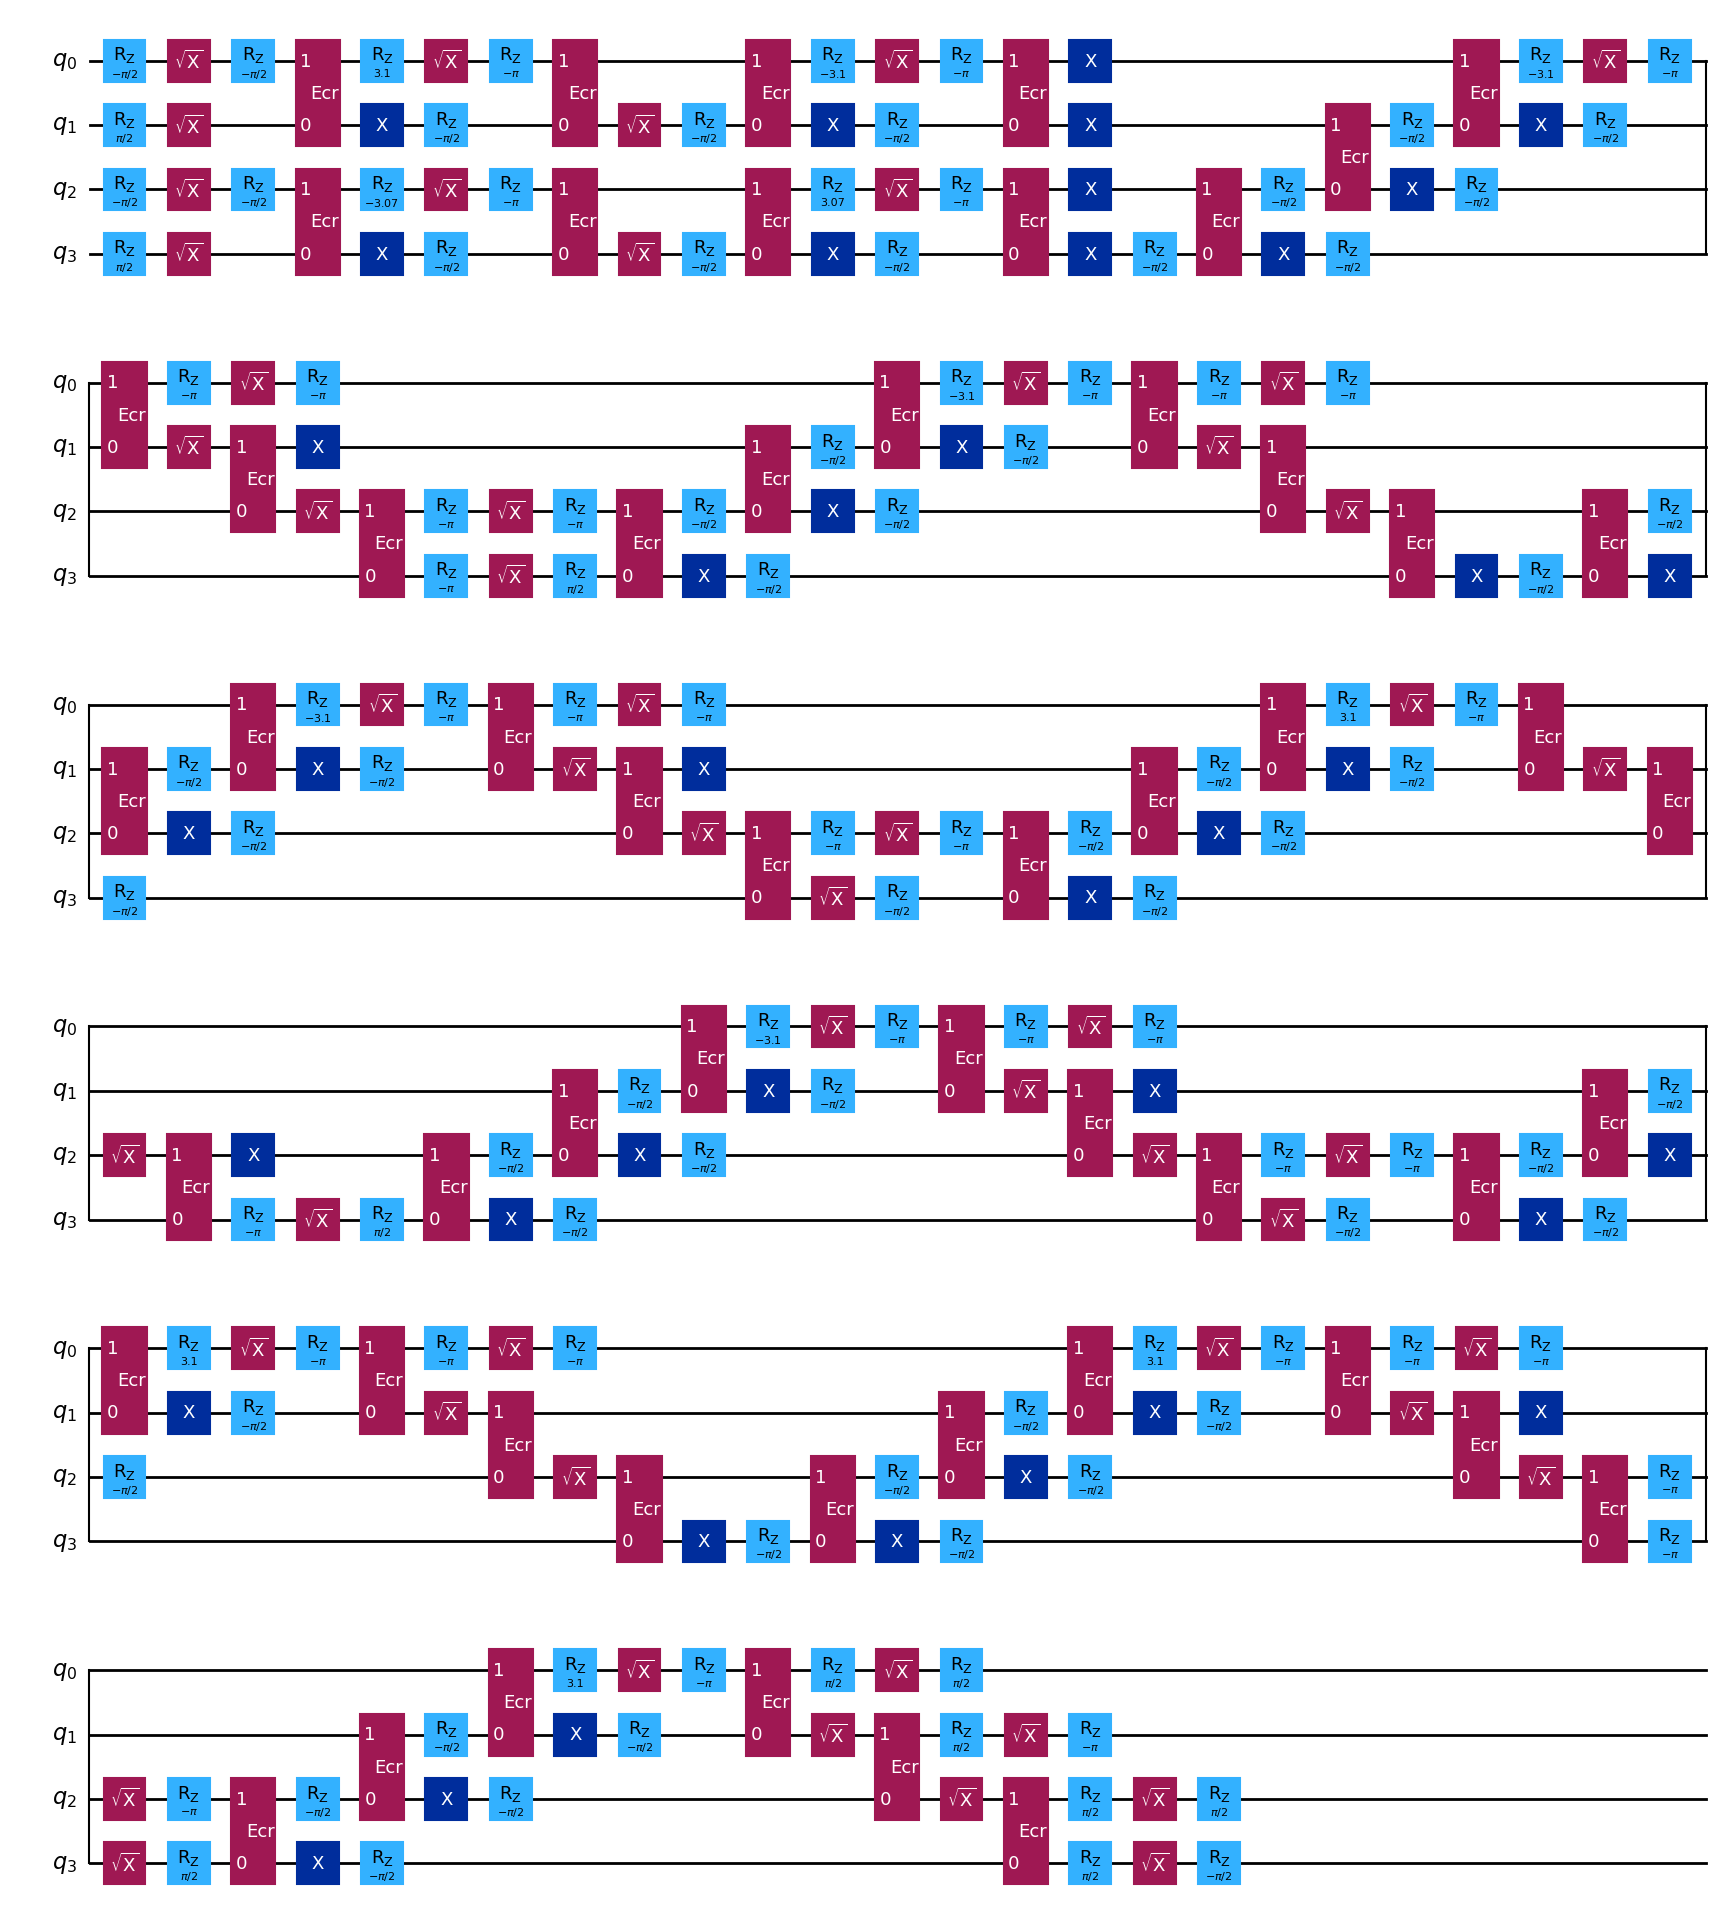

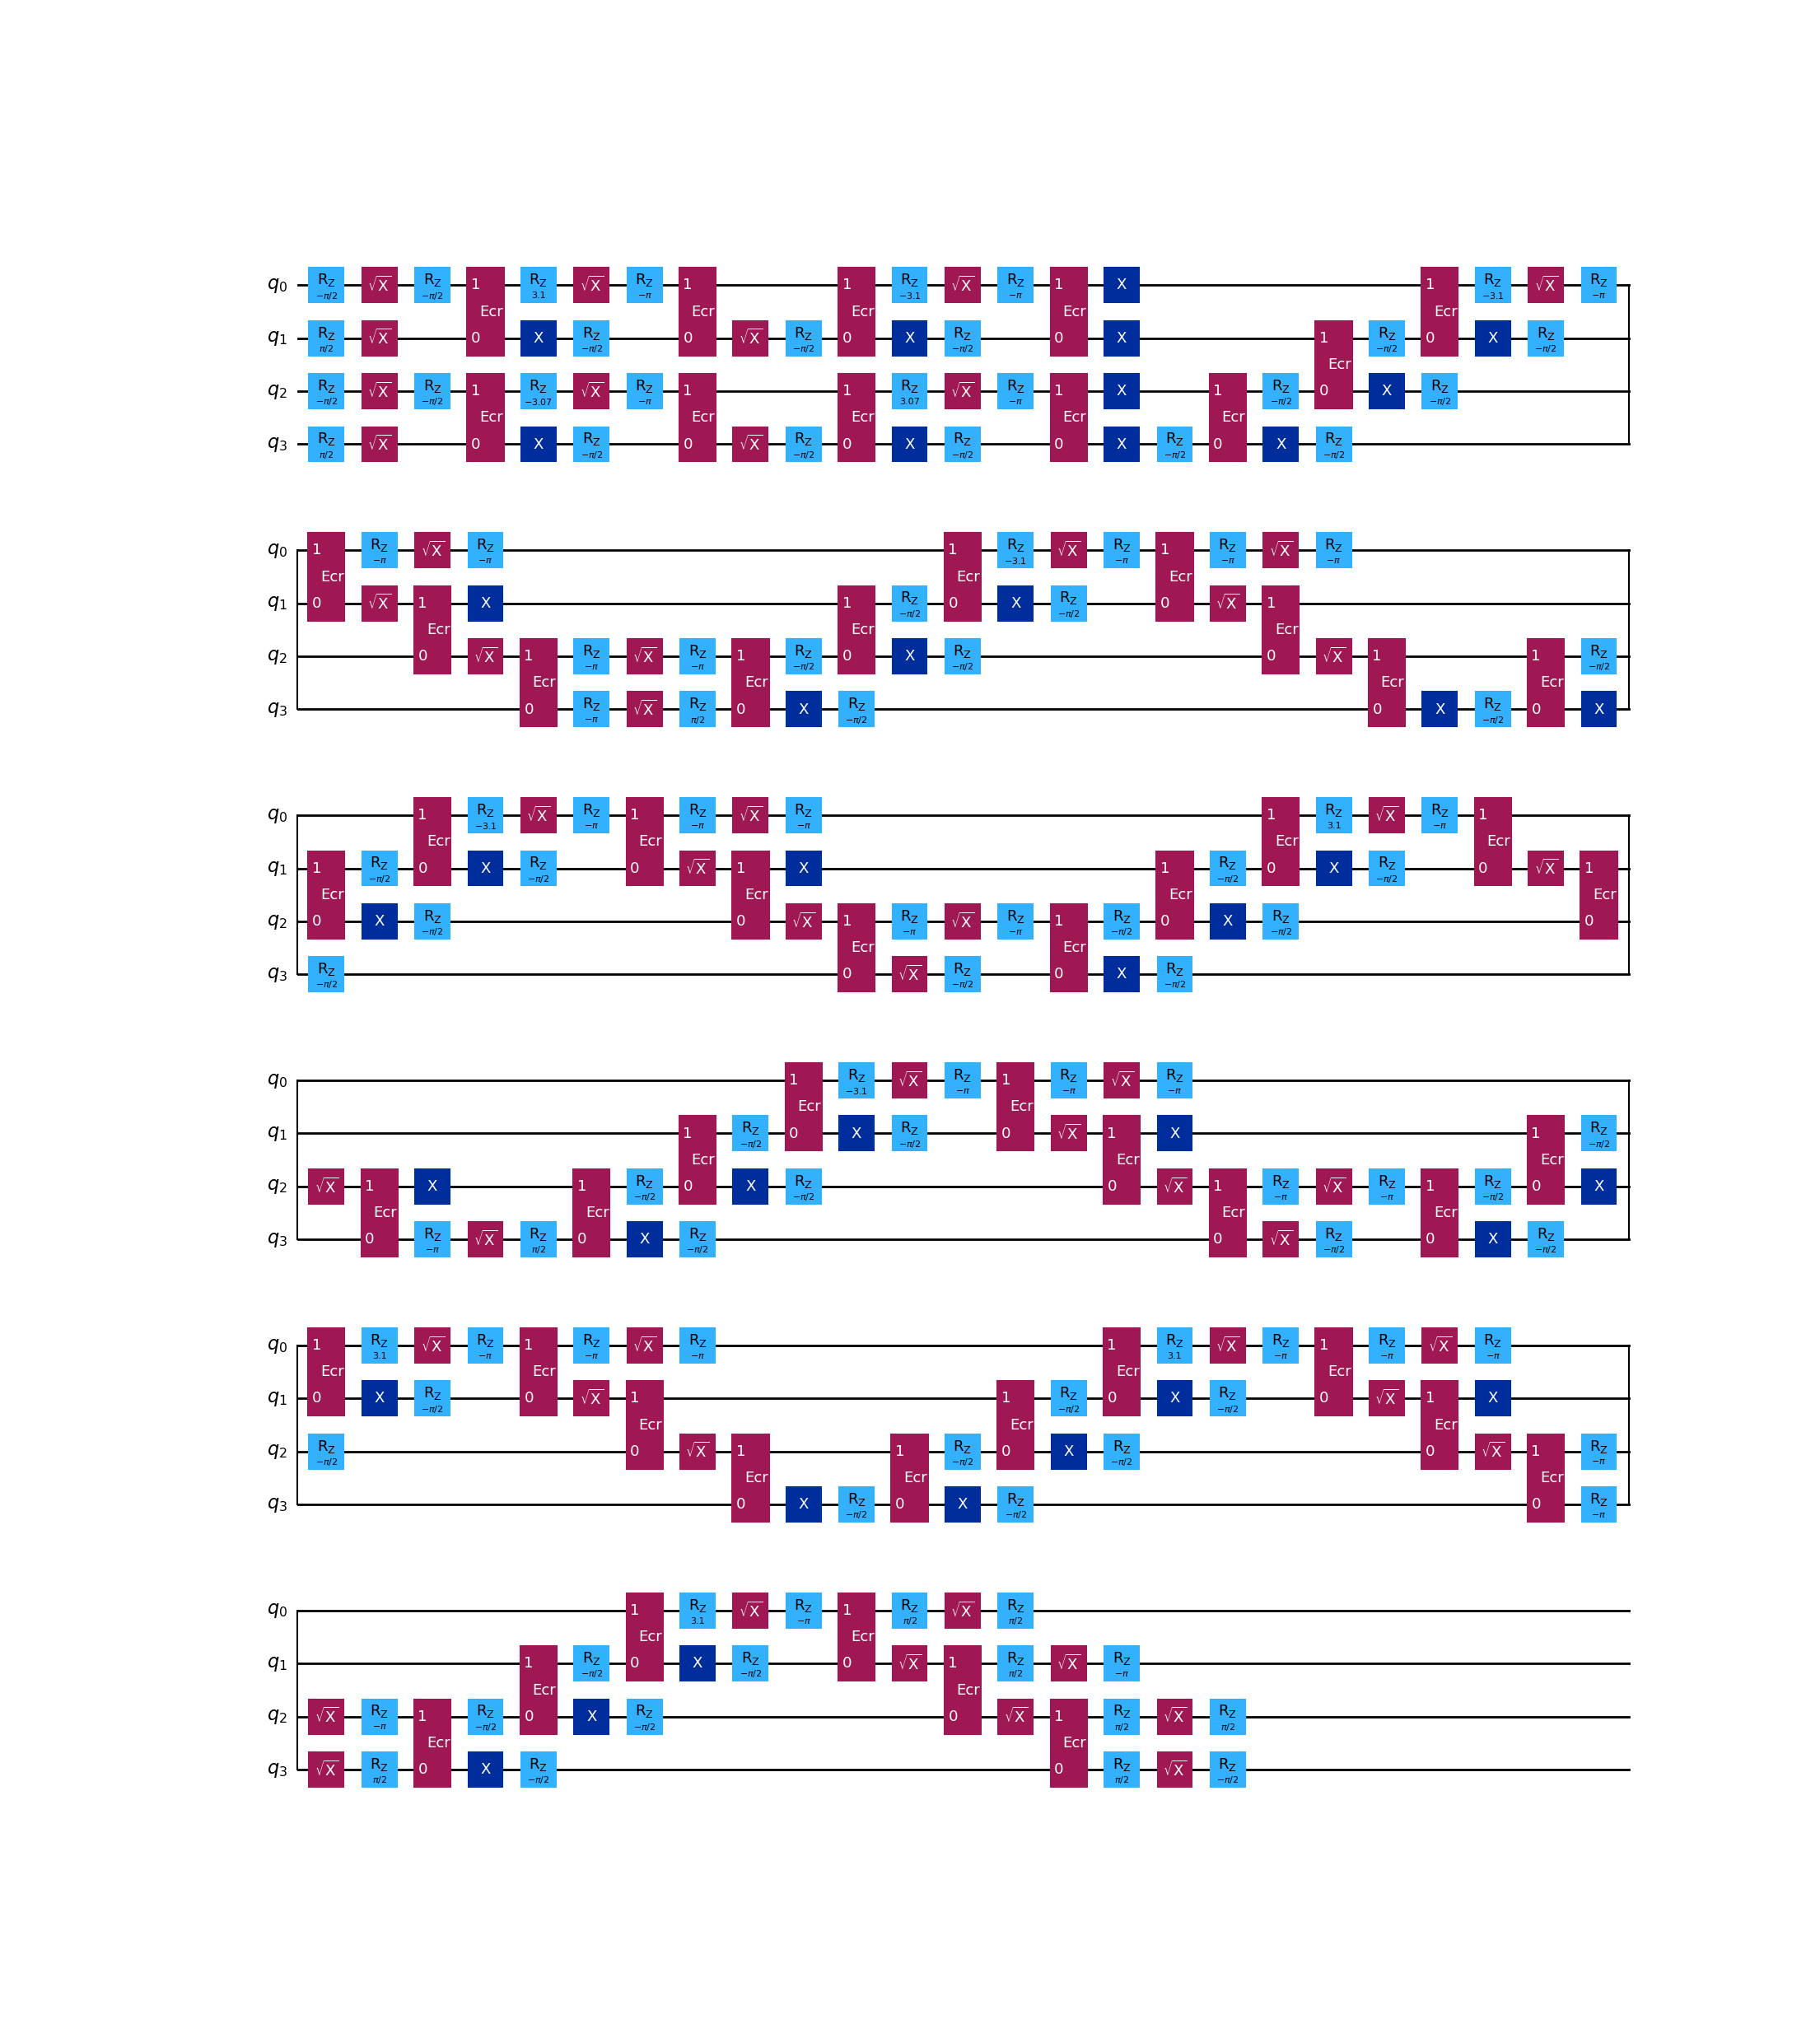

In [28]:
circuito_ibm.draw(output='mpl')

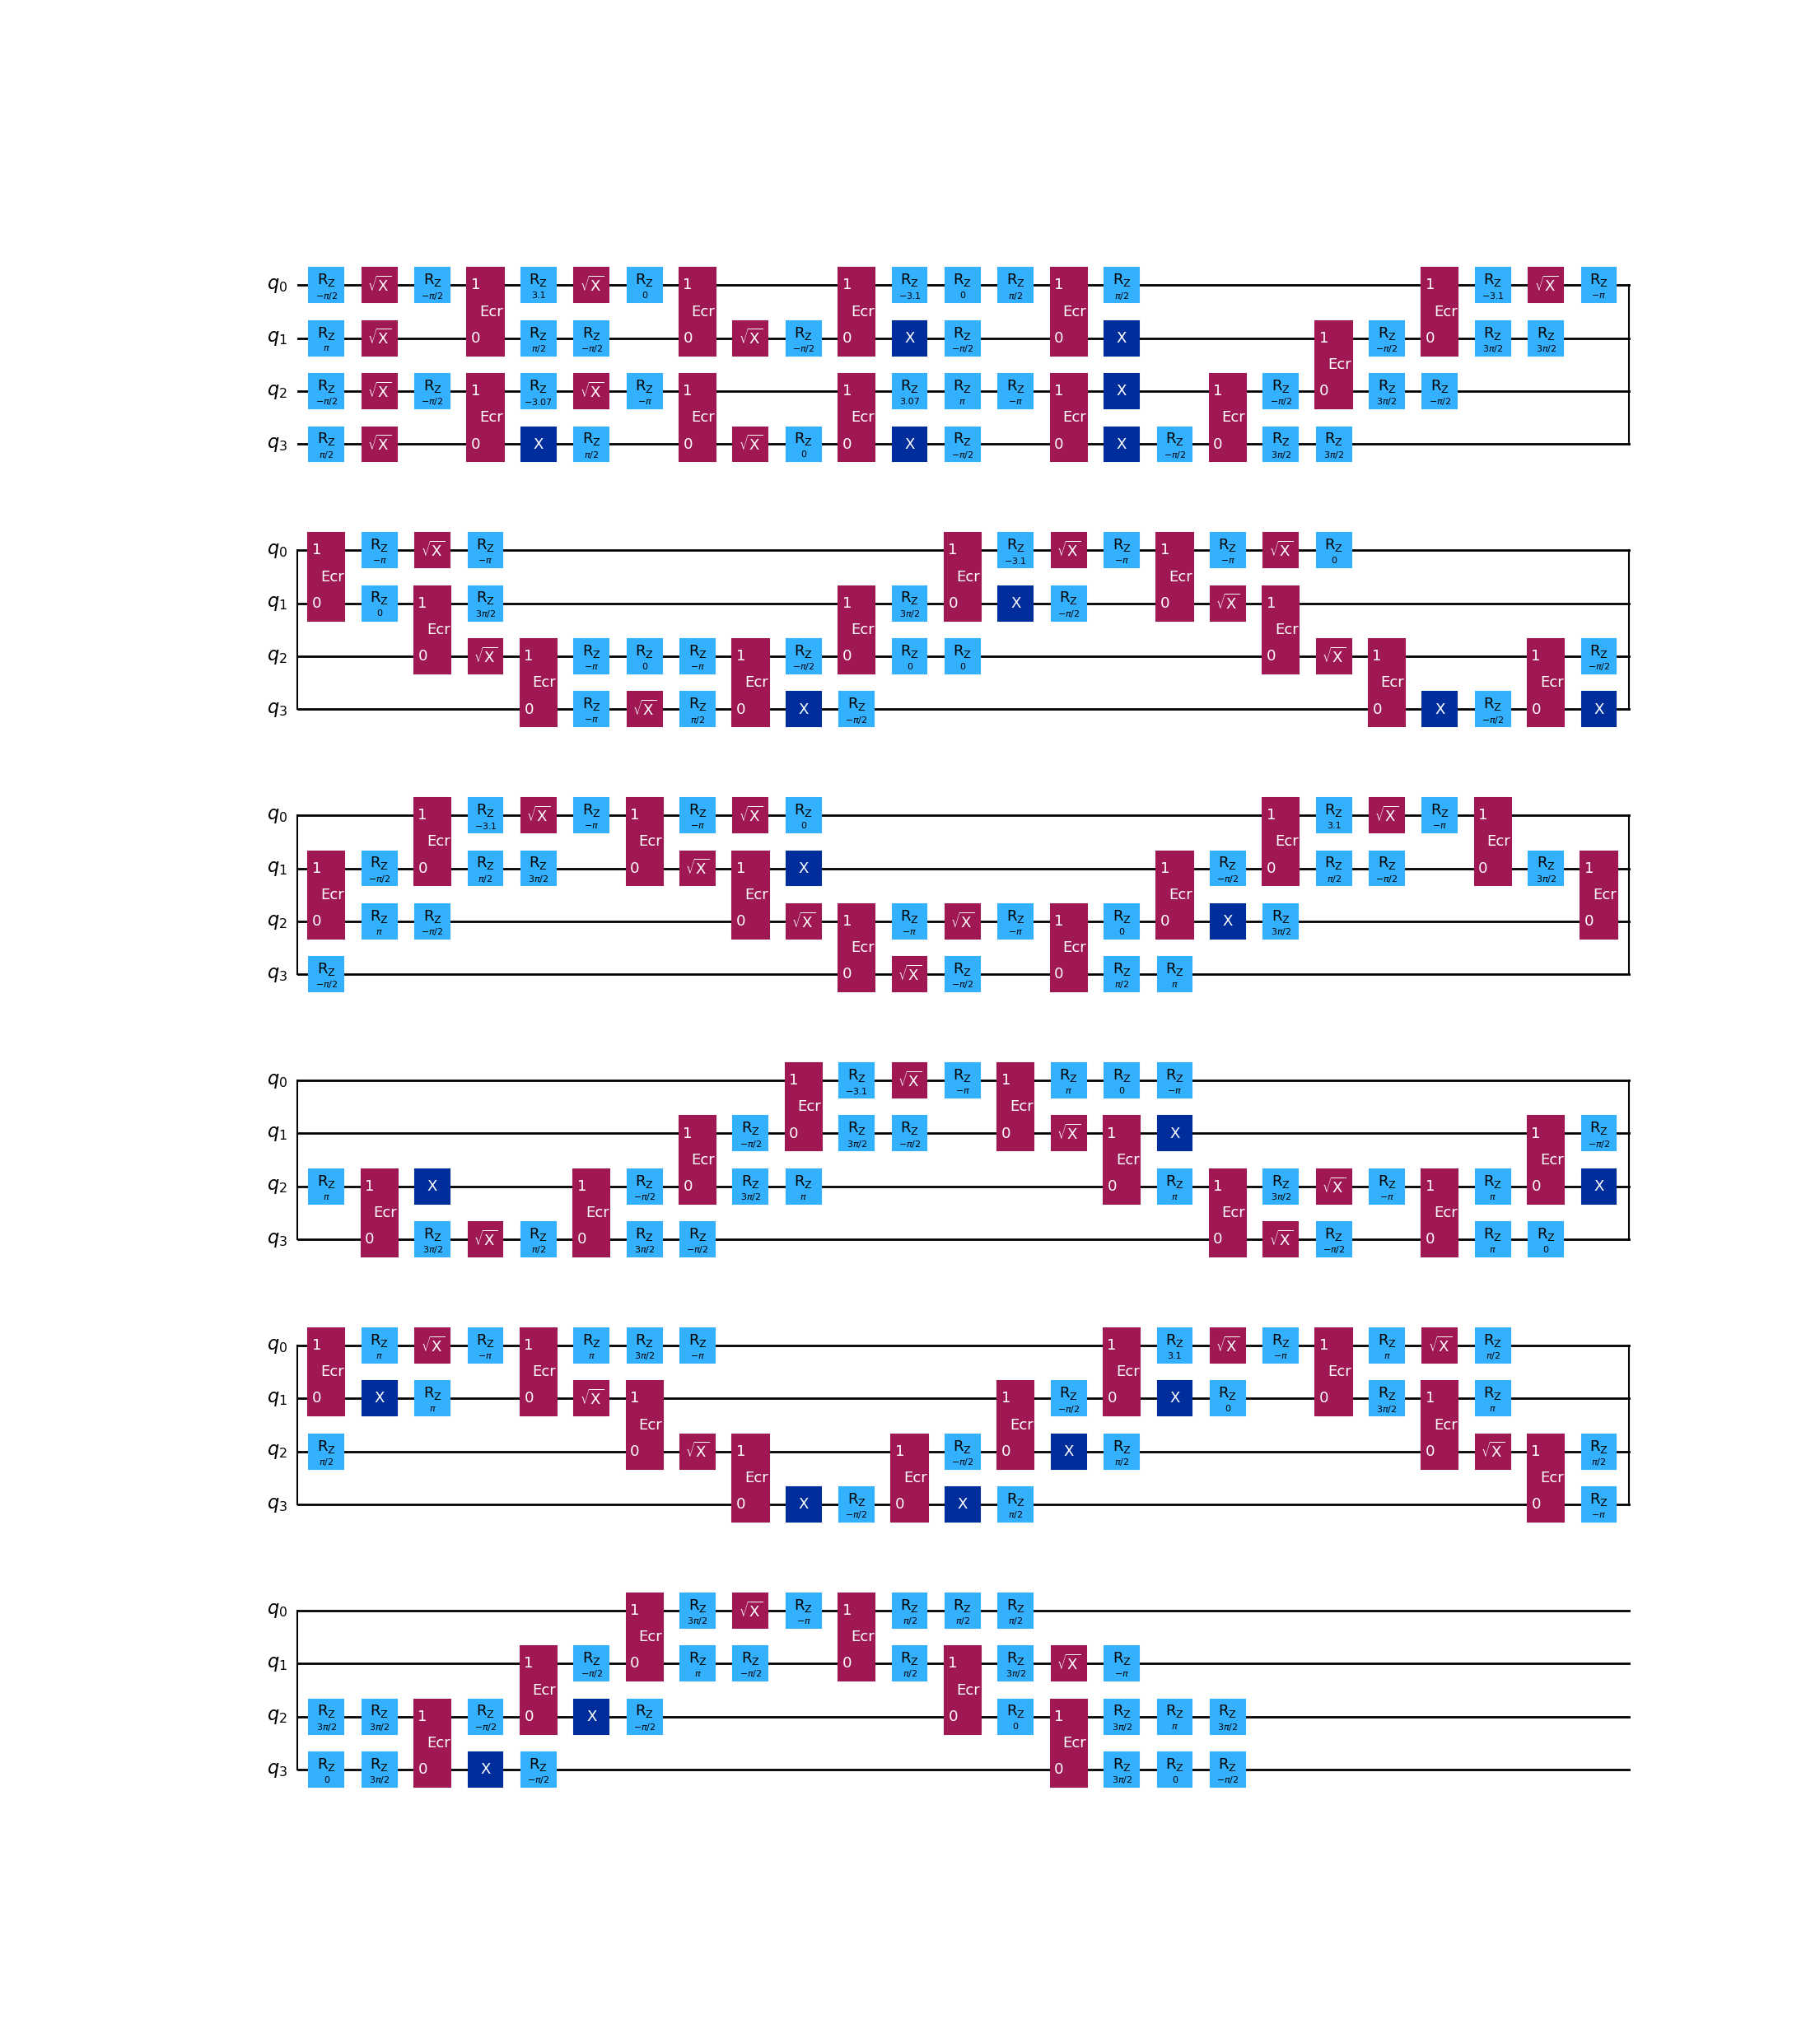

In [27]:
circuito = list(modelo_1(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

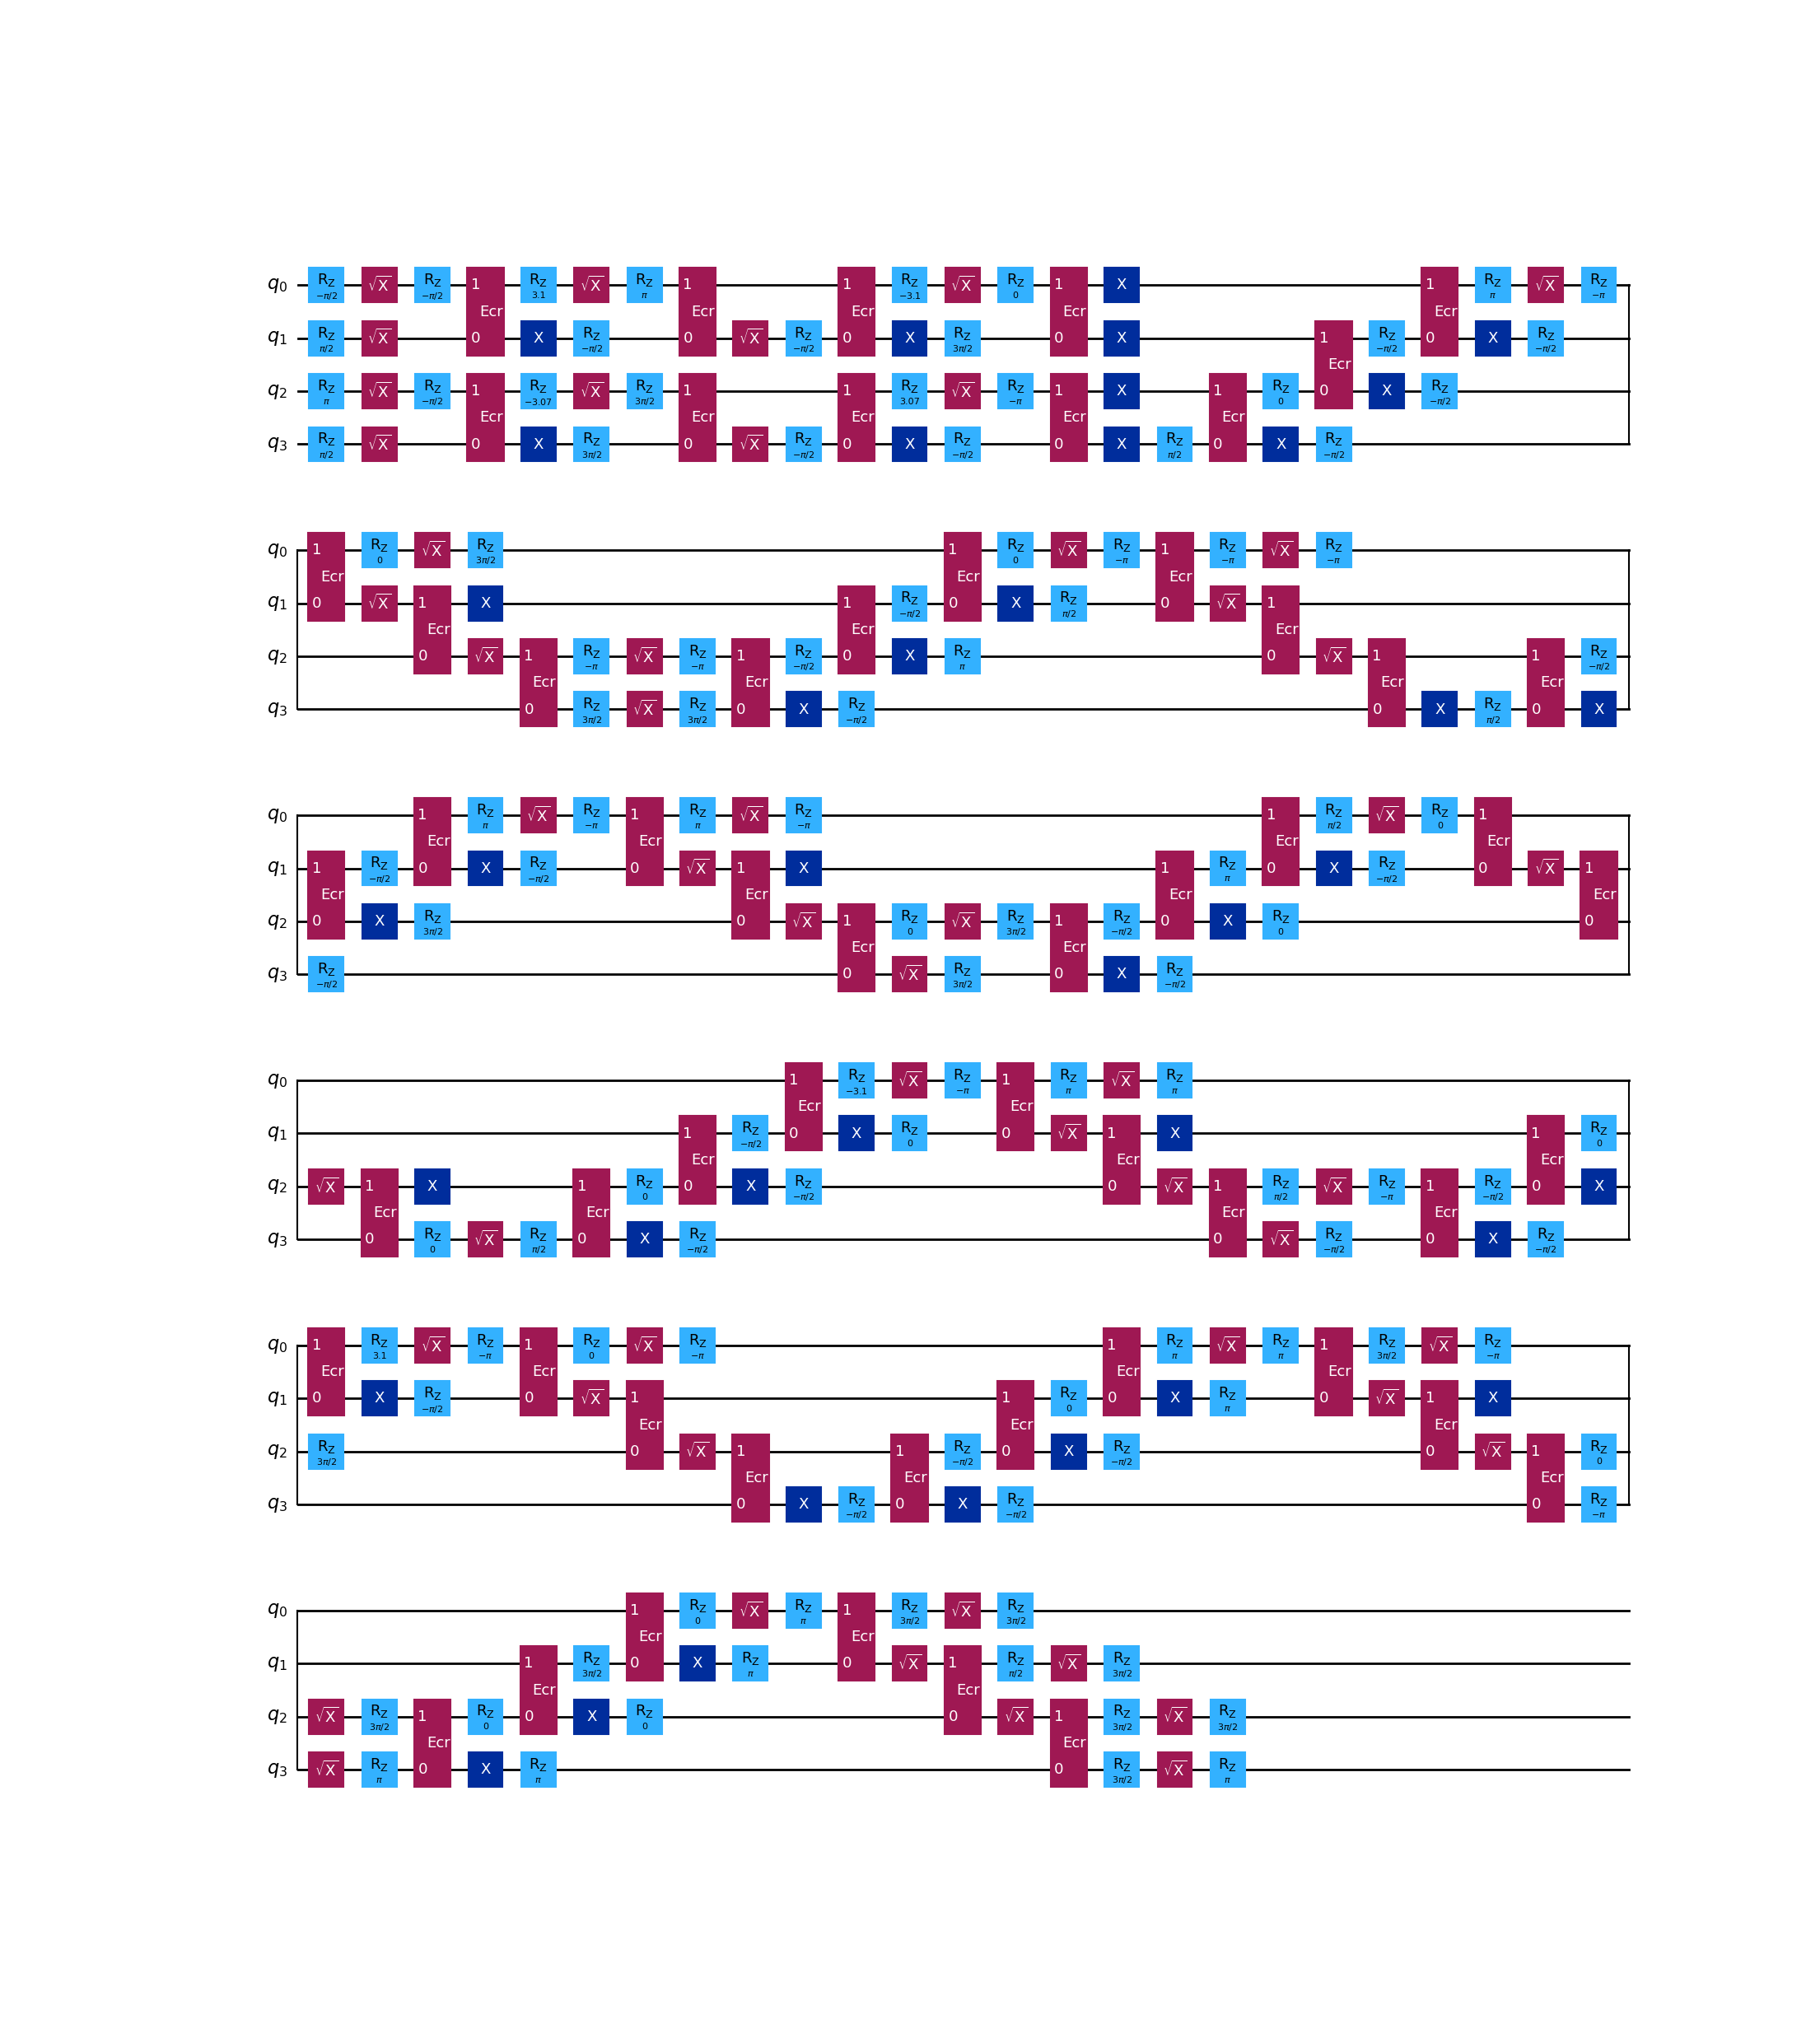

In [29]:
circuito2 = list(modelo_2(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

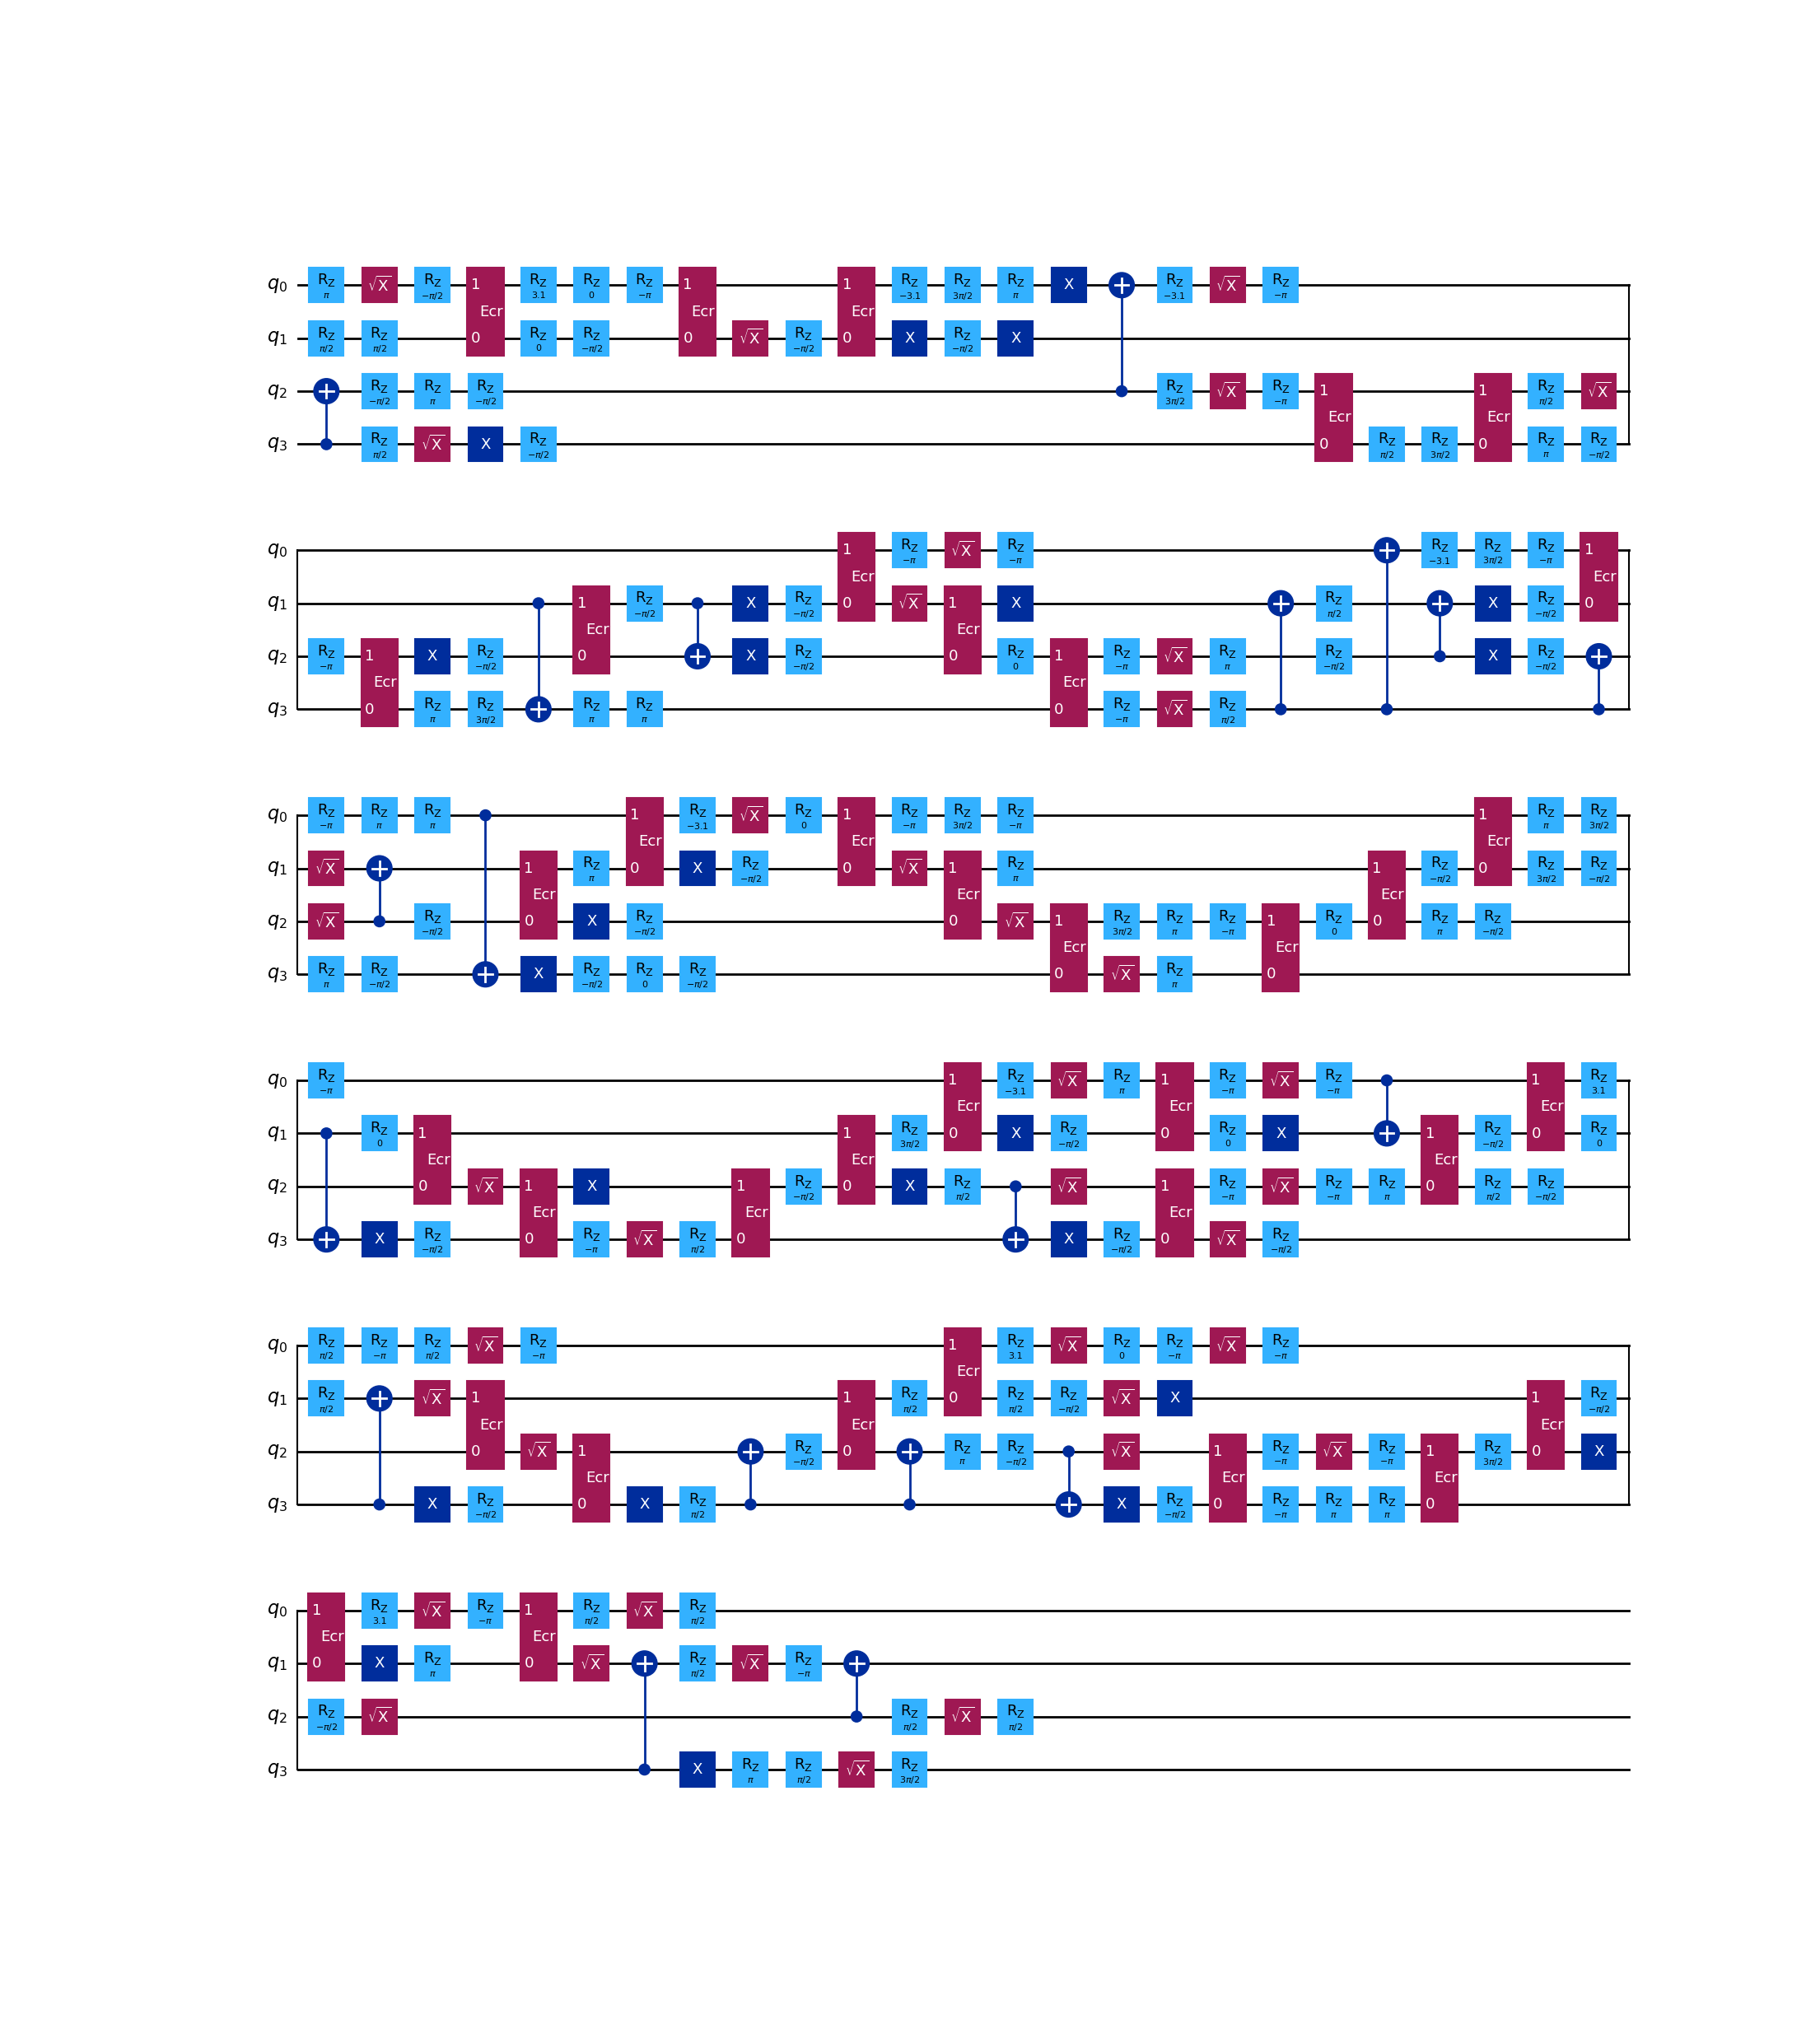

In [51]:
circuito3 = list(modelo_3(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

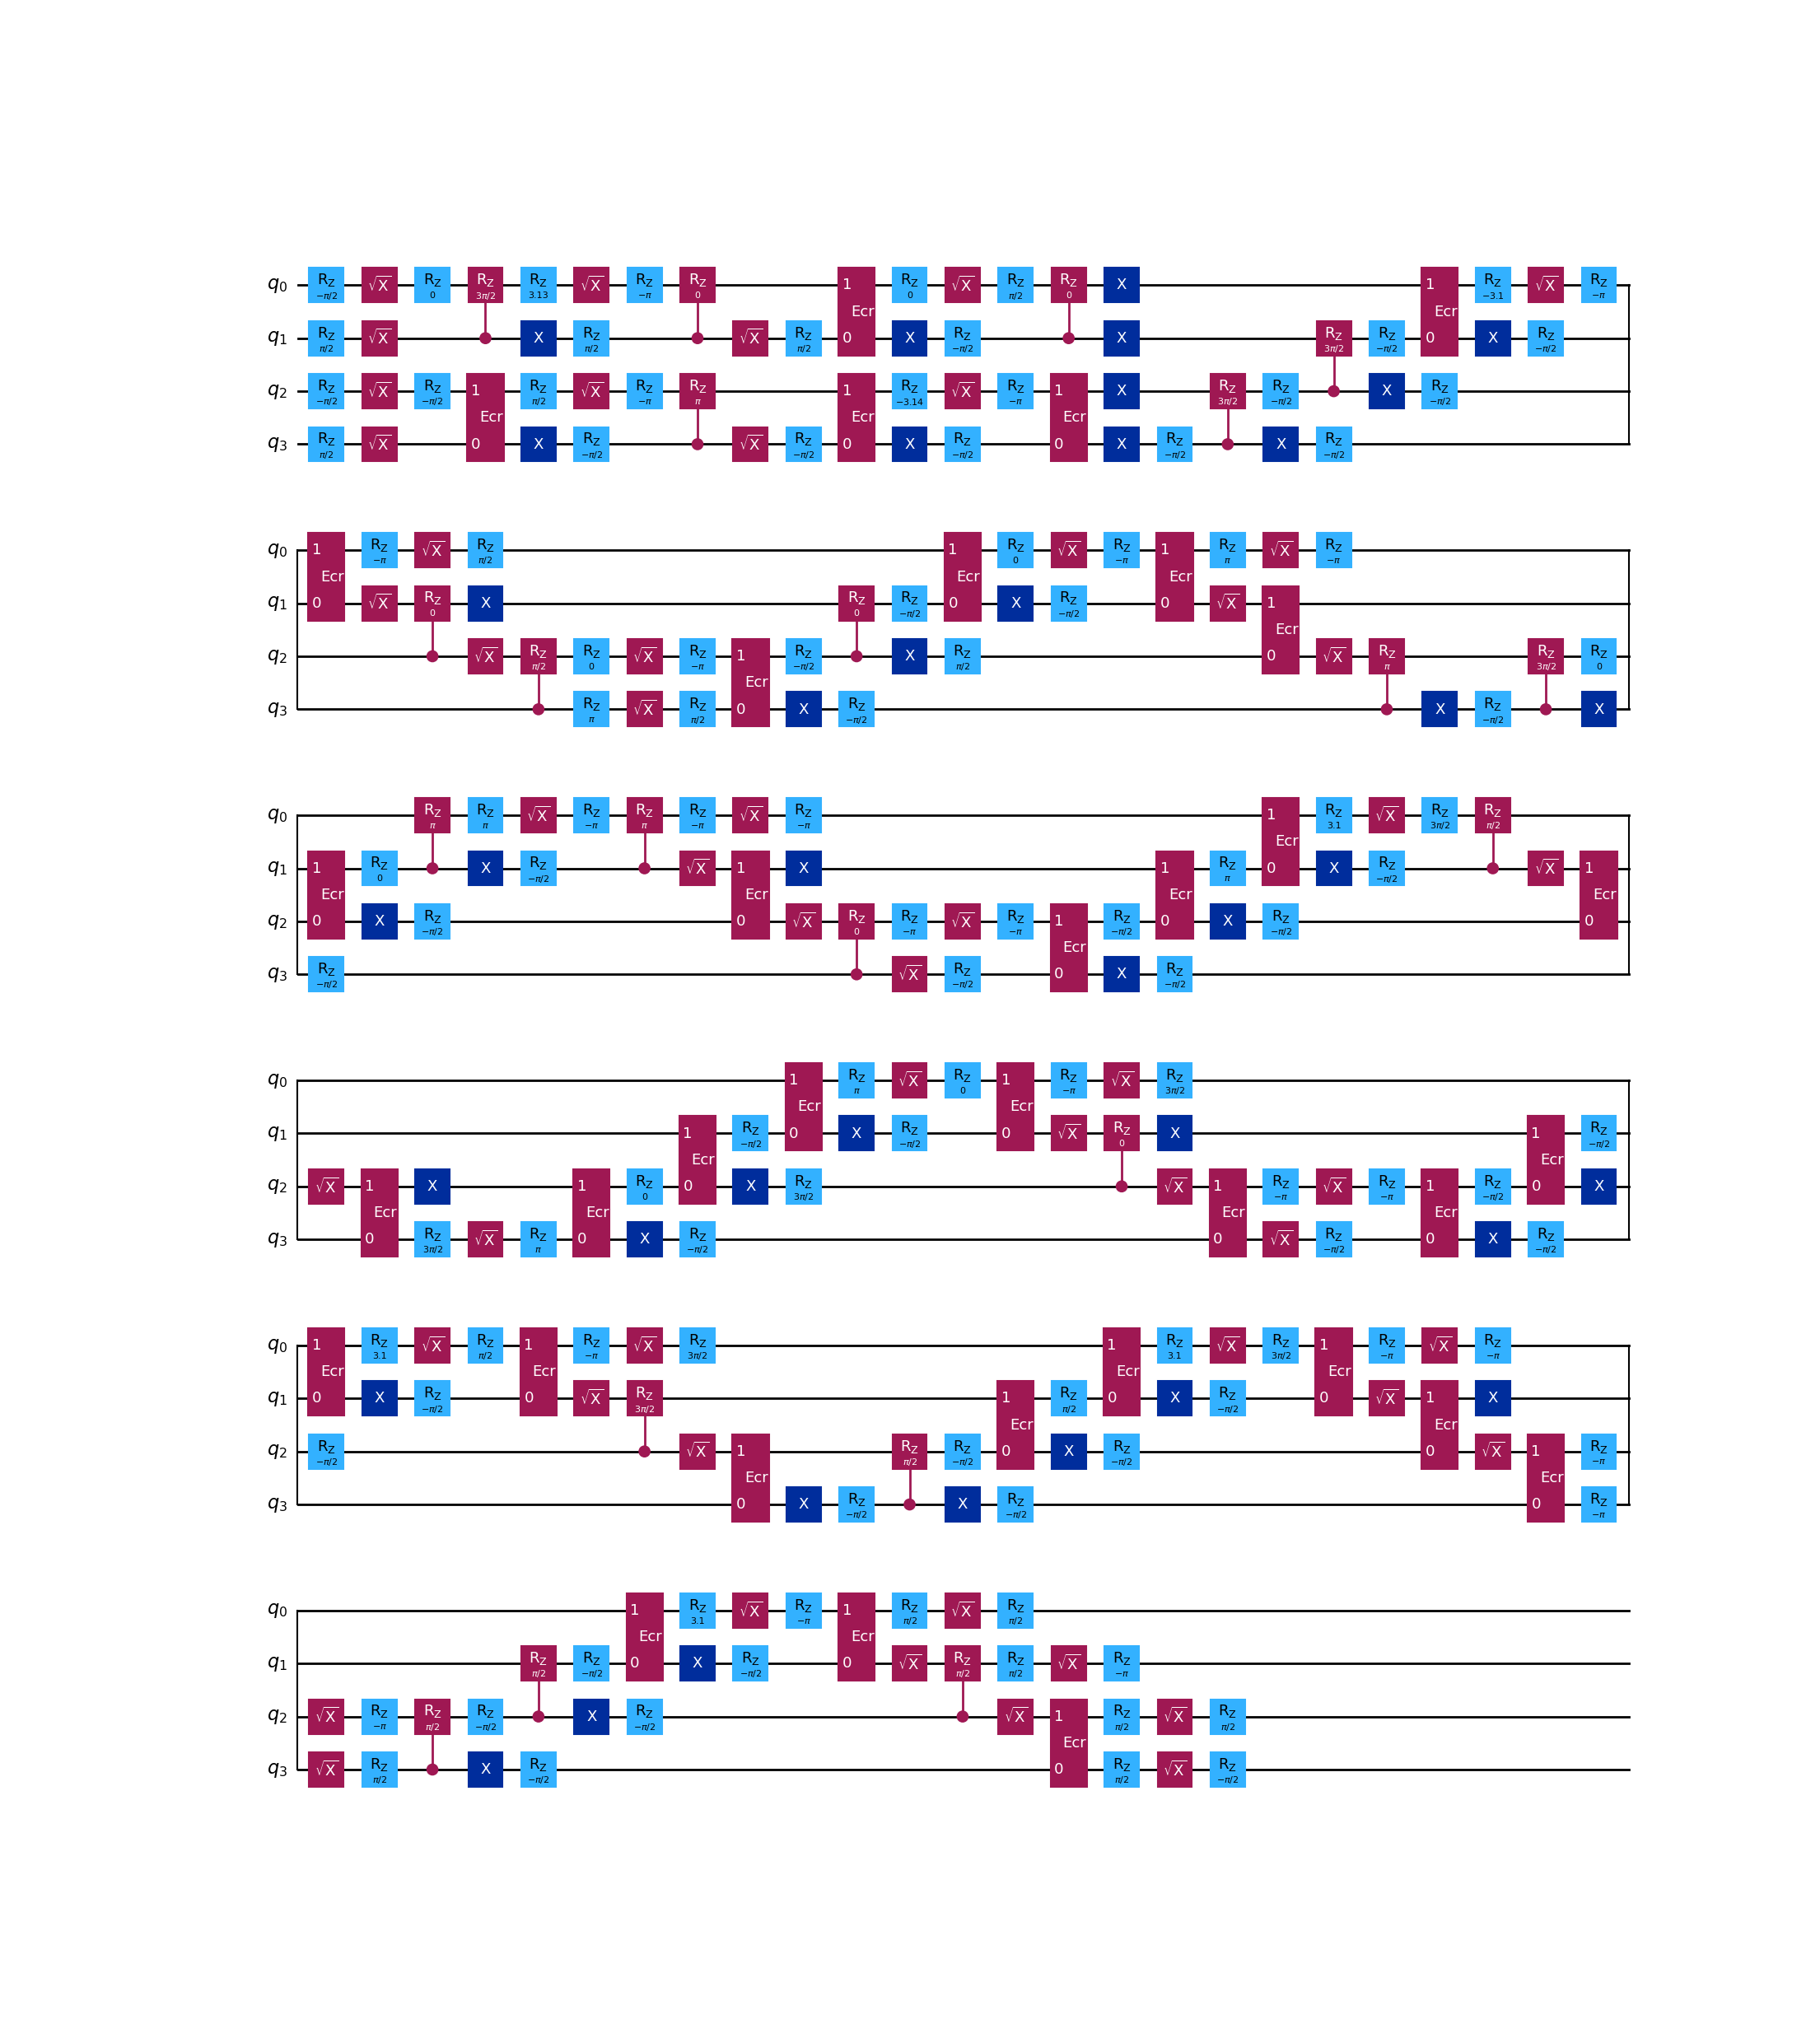

In [10]:
circuito4 = list(modelo_4(circuito_ibm, 1, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = 'estimator_aer', shots = None, seed = 1))[0][0].draw(output='mpl')

# Rodando modelos

# Modelo 1

In [60]:
modelo1_brisbane_3030_aer_2500 = abrir("circuitos_brisbane_3030_aer_2500")
modelo1_brisbane_3030_simulator_2500 = abrir("circuitos_brisbane_3030_simulator_2500")

In [61]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)),
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(modelo1_brisbane_3030_aer_2500):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := modelo1_brisbane_3030_simulator_2500[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_modelo2_brisbane_100 = pd.DataFrame(data)

df_temp = df_modelo2_brisbane_100

show(df_modelo2_brisbane_100)

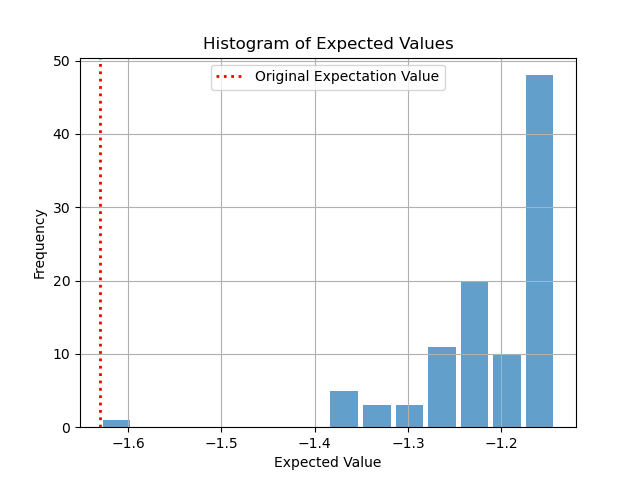

In [62]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.legend()
plt.grid(True)

plt.show()

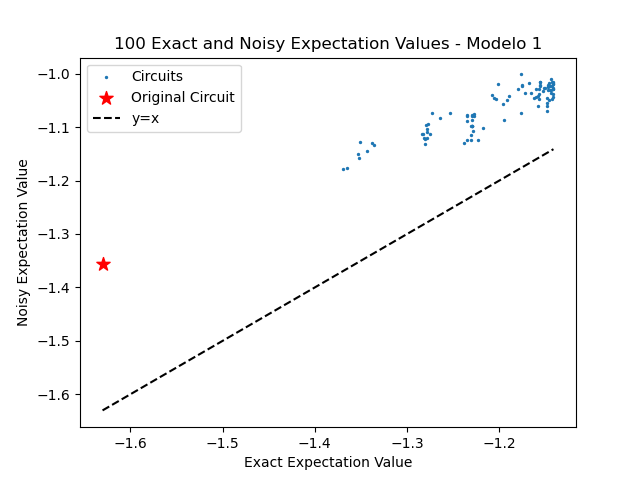

In [63]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 1')
plt.legend()
plt.show()

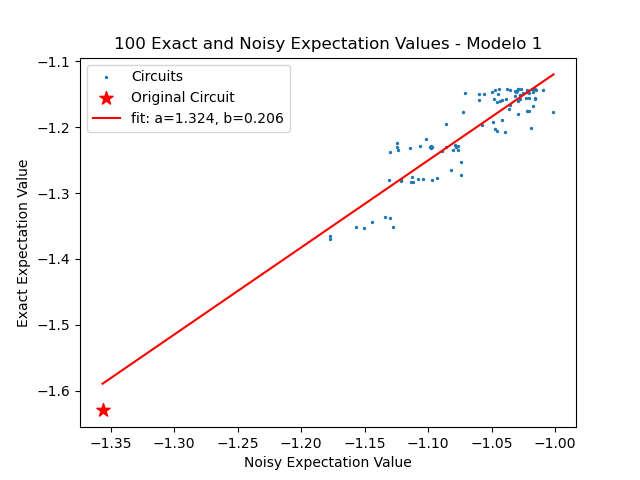

In [64]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 1')
plt.legend()
plt.show()

In [65]:
show(df_temp.head(10))

In [66]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"Original Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

Original Expectation Value: -1.6301357676564663
Noisy Expectation Value: -1.3563983736556835
Corrected Expectation Value: -1.5895954578113054
Percentage Difference: 2.4869284294916665%
Percentage Noisy Difference: 17.192374208406275%


# Modelo 2

In [2]:
modelo = modelo_2(circuito_ibm, 2500, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = "estimator_aer", shots = None, seed = 1)

circuitos_similares_ibm = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(modelo):

    end_time = time.time() - start_time

    circuitos_similares_ibm.append(i)
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

NameError: name 'modelo_2' is not defined

In [15]:
circuitos_similares_ibm_resultados = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(circuitos_similares_ibm):

    end_time = time.time() - start_time
    
    circuitos_similares_ibm_resultados.append([i[0], run_estimator_aer_noise(i[0], es_problem, shots = 2000, seed = 1, noise_model = noise_model)])
    
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 5.078315734863281e-05s
Iteração 1: 2.1457672119140625e-06s
Iteração 2: 1.6689300537109375e-06s
Iteração 3: 1.430511474609375e-06s
Iteração 4: 2.86102294921875e-06s
Iteração 5: 1.9073486328125e-06s
Iteração 6: 1.9073486328125e-06s
Iteração 7: 1.6689300537109375e-06s
Iteração 8: 1.6689300537109375e-06s
Iteração 9: 1.430511474609375e-06s
Iteração 10: 1.6689300537109375e-06s
Iteração 11: 2.86102294921875e-06s
Iteração 12: 1.9073486328125e-06s
Iteração 13: 1.6689300537109375e-06s
Iteração 14: 2.384185791015625e-06s
Iteração 15: 1.430511474609375e-06s
Iteração 16: 1.6689300537109375e-06s
Iteração 17: 1.6689300537109375e-06s
Iteração 18: 2.1457672119140625e-06s
Iteração 19: 1.9073486328125e-06s
Iteração 20: 1.9073486328125e-06s
Iteração 21: 1.9073486328125e-06s
Iteração 22: 1.9073486328125e-06s
Iteração 23: 1.9073486328125e-06s
Iteração 24: 1.9073486328125e-06s
Iteração 25: 1.6689300537109375e-06s
Iteração 26: 1.9073486328125e-06s
Iteração 27: 1.9073486328125e-06s
Iteração 28: 2.3

In [67]:
modelo2_brisbane_3030_aer_2500 = abrir("modelo2_brisbane_3030_aer_2500")
modelo2_brisbane_3030_simulator_2500 = abrir("modelo2_brisbane_3030_simulator_2500")

In [68]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)),
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(modelo2_brisbane_3030_aer_100):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := modelo2_brisbane_3030_simulator_100[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_modelo2_brisbane_100 = pd.DataFrame(data)

df_temp = df_modelo2_brisbane_100

show(df_modelo2_brisbane_100)

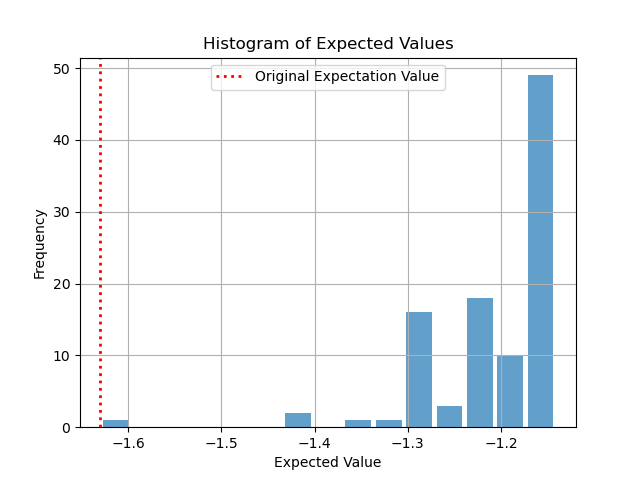

In [69]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.legend()
plt.grid(True)

plt.show()

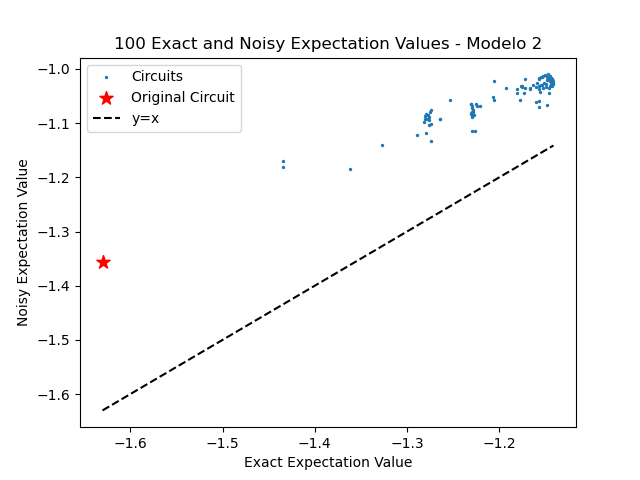

In [70]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 2')
plt.legend()
plt.show()

/tmp/ipykernel_107272/601595822.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


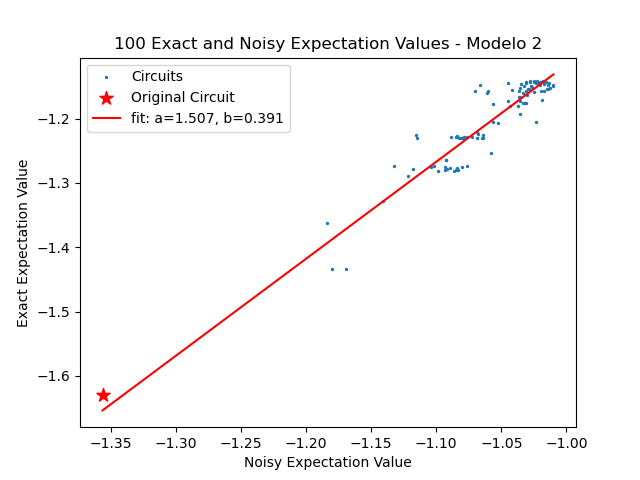

In [71]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 2')
plt.legend()
plt.show()

In [72]:
show(df_temp.head(10))

In [73]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"Original Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

Original Expectation Value: -1.6301357676564663
Noisy Expectation Value: -1.3563983736556835
Corrected Expectation Value: -1.6536033547058864
Percentage Difference: 1.4396093573946802%
Percentage Noisy Difference: 21.911334223233684%


# Modelo 3

In [30]:
modelo = modelo_3(circuito_ibm, 100, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = "estimator_aer", shots = None, seed = 1)

circuitos_similares_ibm = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(modelo):

    end_time = time.time() - start_time

    circuitos_similares_ibm.append(i)
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 1.5259151458740234s
Iteração 1: 0.37264084815979004s
Iteração 2: 1.4001281261444092s
Iteração 3: 4.395399570465088s
Iteração 4: 1.754662275314331s
Iteração 5: 0.48034167289733887s
Iteração 6: 1.0840983390808105s
Iteração 7: 4.718238592147827s
Iteração 8: 6.113032341003418s
Iteração 9: 6.218790054321289s
Iteração 10: 8.274013996124268s
Iteração 11: 4.424394130706787s
Iteração 12: 0.22628474235534668s
Iteração 13: 0.6611080169677734s
Iteração 14: 0.7516257762908936s
Iteração 15: 1.9677066802978516s
Iteração 16: 0.5891668796539307s
Iteração 17: 5.4121692180633545s
Iteração 18: 0.4087979793548584s
Iteração 19: 1.9341671466827393s
Iteração 20: 1.563199520111084s
Iteração 21: 0.4671142101287842s
Iteração 22: 1.8554744720458984s
Iteração 23: 1.7343847751617432s
Iteração 24: 0.4562690258026123s
Iteração 25: 0.6422922611236572s
Iteração 26: 1.157888650894165s
Iteração 27: 4.078423976898193s
Iteração 28: 0.26651668548583984s
Iteração 29: 4.212808609008789s
Iteração 30: 3.198807239532

In [31]:
circuitos_similares_ibm_resultados = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(circuitos_similares_ibm):

    end_time = time.time() - start_time
    
    circuitos_similares_ibm_resultados.append([i[0], run_estimator_aer_noise(i[0], es_problem, shots = 2000, seed = 1, noise_model = noise_model)])
    
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 5.125999450683594e-05s
Iteração 1: 1.6689300537109375e-06s
Iteração 2: 1.6689300537109375e-06s
Iteração 3: 1.6689300537109375e-06s
Iteração 4: 2.1457672119140625e-06s
Iteração 5: 1.6689300537109375e-06s
Iteração 6: 2.384185791015625e-06s
Iteração 7: 1.9073486328125e-06s
Iteração 8: 1.9073486328125e-06s
Iteração 9: 2.384185791015625e-06s
Iteração 10: 2.6226043701171875e-06s
Iteração 11: 2.1457672119140625e-06s
Iteração 12: 1.6689300537109375e-06s
Iteração 13: 1.9073486328125e-06s
Iteração 14: 1.9073486328125e-06s
Iteração 15: 1.6689300537109375e-06s
Iteração 16: 2.1457672119140625e-06s
Iteração 17: 1.9073486328125e-06s
Iteração 18: 1.6689300537109375e-06s
Iteração 19: 2.384185791015625e-06s
Iteração 20: 1.9073486328125e-06s
Iteração 21: 1.9073486328125e-06s
Iteração 22: 1.6689300537109375e-06s
Iteração 23: 1.6689300537109375e-06s
Iteração 24: 1.430511474609375e-06s
Iteração 25: 1.6689300537109375e-06s
Iteração 26: 1.6689300537109375e-06s
Iteração 27: 2.1457672119140625e-06s


In [34]:
modelo3_brisbane_3030_aer_100 = circuitos_similares_ibm
modelo3_brisbane_3030_simulator_100 = circuitos_similares_ibm_resultados

salvar("modelo3_brisbane_3030_aer_100")
salvar("modelo3_brisbane_3030_simulator_100")

In [35]:
modelo3_brisbane_3030_aer_100 = abrir("modelo3_brisbane_3030_aer_100")
modelo3_brisbane_3030_simulator_100 = abrir("modelo3_brisbane_3030_simulator_100")

In [36]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)),
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(modelo3_brisbane_3030_aer_100):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := modelo3_brisbane_3030_simulator_100[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_modelo3_brisbane_100 = pd.DataFrame(data)

df_temp = df_modelo3_brisbane_100

show(df_modelo3_brisbane_100)

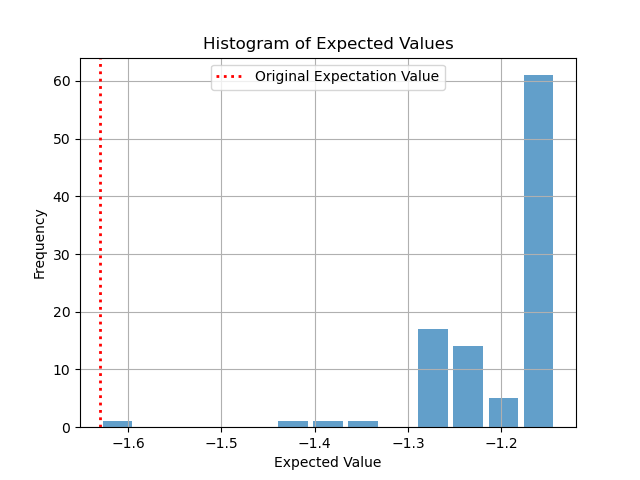

In [37]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.legend()
plt.grid(True)

plt.show()

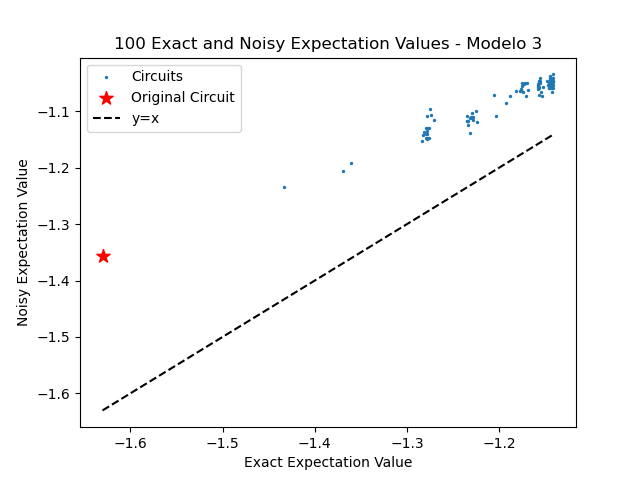

In [38]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 3')
plt.legend()
plt.show()

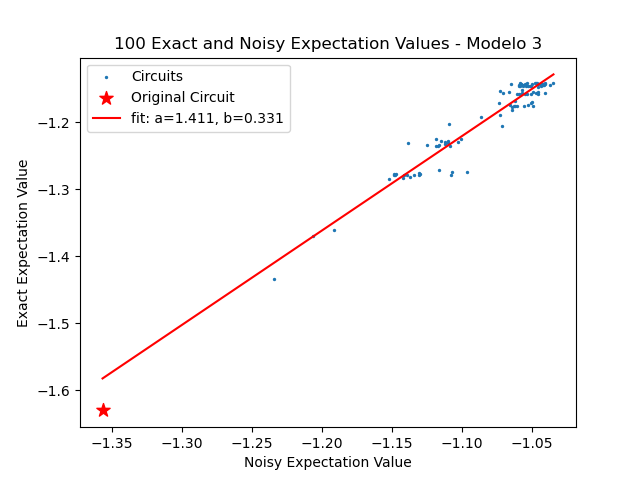

In [39]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 3')
plt.legend()
plt.show()

In [40]:
show(df_temp.head(10))

In [45]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"Original Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

Original Expectation Value: -1.6301357676564663
Noisy Expectation Value: -1.3563983736556835
Corrected Expectation Value: -1.5824354556881044
Percentage Difference: 2.9261557788488584%
Percentage Noisy Difference: 16.664505533372125%


# Modelo 4

In [46]:
modelo = modelo_4(circuito_ibm, 100, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = "estimator_aer", shots = None, seed = 1)

circuitos_similares_ibm = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(modelo):

    end_time = time.time() - start_time

    circuitos_similares_ibm.append(i)
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 3.757171630859375s
Iteração 1: 10.698051929473877s
Iteração 2: 6.128923177719116s
Iteração 3: 1.8147578239440918s
Iteração 4: 1.1529841423034668s
Iteração 5: 16.92433476448059s
Iteração 6: 5.606555938720703s
Iteração 7: 14.363633871078491s
Iteração 8: 13.196182012557983s
Iteração 9: 20.507747173309326s
Iteração 10: 3.3116300106048584s
Iteração 11: 9.84130072593689s
Iteração 12: 19.248587369918823s
Iteração 13: 1.8361949920654297s
Iteração 14: 5.813957452774048s
Iteração 15: 6.694728851318359s
Iteração 16: 14.947479486465454s
Iteração 17: 8.293883562088013s
Iteração 18: 35.63820457458496s
Iteração 19: 4.501638650894165s
Iteração 20: 0.841684103012085s
Iteração 21: 25.897849321365356s
Iteração 22: 1.6992619037628174s
Iteração 23: 4.086957216262817s
Iteração 24: 23.65266227722168s
Iteração 25: 8.581653356552124s
Iteração 26: 23.572185516357422s
Iteração 27: 16.68946647644043s
Iteração 28: 23.079953908920288s
Iteração 29: 20.476309537887573s
Iteração 30: 19.130577087402344s
Ite

In [47]:
circuitos_similares_ibm_resultados = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(circuitos_similares_ibm):

    end_time = time.time() - start_time
    
    circuitos_similares_ibm_resultados.append([i[0], run_estimator_aer_noise(i[0], es_problem, shots = 2000, seed = 1, noise_model = noise_model)])
    
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 5.173683166503906e-05s
Iteração 1: 2.6226043701171875e-06s
Iteração 2: 1.6689300537109375e-06s
Iteração 3: 1.9073486328125e-06s
Iteração 4: 1.9073486328125e-06s
Iteração 5: 1.9073486328125e-06s
Iteração 6: 1.9073486328125e-06s
Iteração 7: 2.384185791015625e-06s
Iteração 8: 1.9073486328125e-06s
Iteração 9: 1.9073486328125e-06s
Iteração 10: 1.6689300537109375e-06s
Iteração 11: 1.9073486328125e-06s
Iteração 12: 1.9073486328125e-06s
Iteração 13: 1.430511474609375e-06s
Iteração 14: 1.430511474609375e-06s
Iteração 15: 1.6689300537109375e-06s
Iteração 16: 1.6689300537109375e-06s
Iteração 17: 1.9073486328125e-06s
Iteração 18: 1.9073486328125e-06s
Iteração 19: 1.6689300537109375e-06s
Iteração 20: 2.1457672119140625e-06s
Iteração 21: 1.9073486328125e-06s
Iteração 22: 1.6689300537109375e-06s
Iteração 23: 1.6689300537109375e-06s
Iteração 24: 3.337860107421875e-06s
Iteração 25: 2.1457672119140625e-06s
Iteração 26: 2.6226043701171875e-06s
Iteração 27: 1.6689300537109375e-06s
Iteração 28:

In [49]:
modelo4_brisbane_3030_aer_100 = circuitos_similares_ibm
modelo4_brisbane_3030_simulator_100 = circuitos_similares_ibm_resultados

salvar("modelo4_brisbane_3030_aer_100")
salvar("modelo4_brisbane_3030_simulator_100")

In [74]:
modelo4_brisbane_3030_aer_100 = abrir("modelo4_brisbane_3030_aer_100")
modelo4_brisbane_3030_simulator_100 = abrir("modelo4_brisbane_3030_simulator_100")

In [75]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)),
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(modelo4_brisbane_3030_aer_100):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := modelo4_brisbane_3030_simulator_100[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_modelo3_brisbane_100 = pd.DataFrame(data)

df_temp = df_modelo3_brisbane_100

show(df_modelo3_brisbane_100)

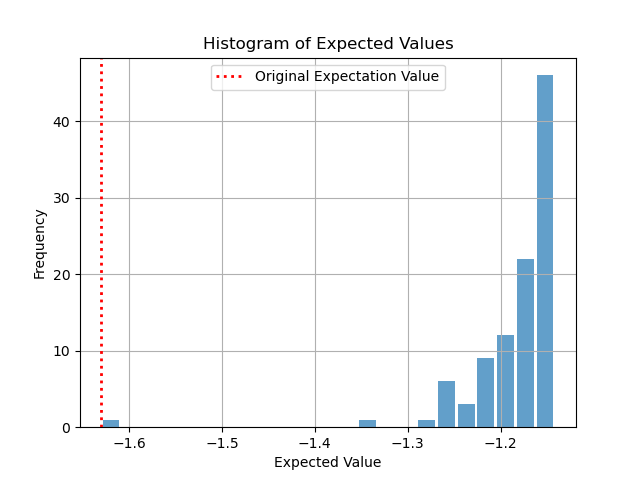

In [76]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.legend()
plt.grid(True)

plt.show()

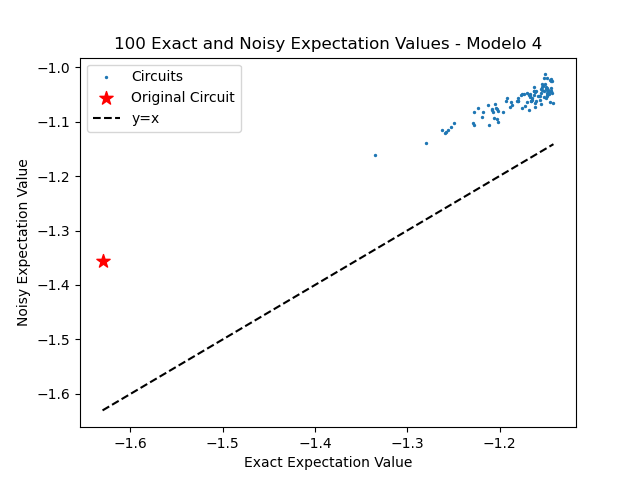

In [77]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 4')
plt.legend()
plt.show()

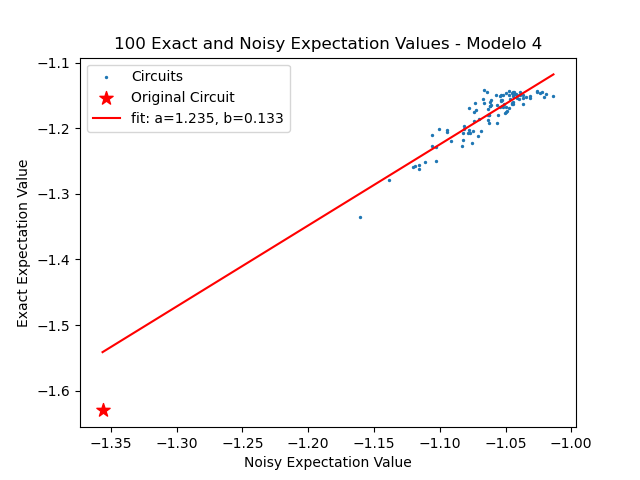

In [78]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title('100 Exact and Noisy Expectation Values - Modelo 4')
plt.legend()
plt.show()

In [79]:
show(df_temp.head(10))

In [80]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"Original Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

Original Expectation Value: -1.6301357676564663
Noisy Expectation Value: -1.3563983736556835
Corrected Expectation Value: -1.5413292119361064
Percentage Difference: 5.447801188242802%
Percentage Noisy Difference: 13.633961959273691%


# Resultados Finais

Original Expectation Value: -1.6301357676564663

Modelo 1

Noisy Expectation Value: -1.3563983736556835

Corrected Expectation Value: -1.5895954578113054

Percentage Difference: 2.4869284294916665%

Percentage Noisy Difference: 17.192374208406275%

Modelo 2

Noisy Expectation Value: -1.3563983736556835

Corrected Expectation Value: -1.6536033547058864

Percentage Difference: 1.4396093573946802%

Percentage Noisy Difference: 21.911334223233684%

Modelo 3

Noisy Expectation Value: -1.3563983736556835

Corrected Expectation Value: -1.5824354556881044

Percentage Difference: 2.9261557788488584%

Percentage Noisy Difference: 16.664505533372125%

Modelo 4

Noisy Expectation Value: -1.3563983736556835

Corrected Expectation Value: -1.5413292119361064

Percentage Difference: 5.447801188242802%

Percentage Noisy Difference: 13.633961959273691%